El siguiente codigo se basa en desarrollar una red neuronal para el pronostico de energia solar a corto plazo mediante python, se utiliza datos diarios obtenidos de: 
https://github.com/ColasGael/Machine-Learning-for-Solar-Energy-Prediction

En especifico, datos de producción diaria de energía del parque solar Urbana-Champaign y cobertura nubosa.

In [1]:
#Importar librerias utilizadas y leyendo datos

import matplotlib as mp 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

#el formato de archivo es en excel
archivo_xlsx = 'datos_red1.xlsx' 

#leer el archivo .xlsx en un DataFrame
data = pd.read_excel(archivo_xlsx)
print(data.head()) #mostrar el inicio del DataFrame

        Date  Cloud coverage  Visibility  Temperature  Dew point  \
0 2016-02-01            0.10        9.45         3.11       0.32   
1 2016-02-02            0.80        3.94         6.99       6.22   
2 2016-02-03            0.87        8.70         1.62       0.02   
3 2016-02-04            0.37       10.00        -2.47      -5.89   
4 2016-02-05            0.52        9.21        -2.00      -4.15   

   Relative humidity  Wind speed  Station pressure  Altimeter  Solar energy  \
0              79.46        4.70             29.23      30.02         20256   
1              93.60       13.29             28.91      29.70          1761   
2              85.00       16.73             29.03      29.82          2775   
3              74.52        9.46             29.46      30.26         28695   
4              82.03        5.92             29.55      30.35          9517   

   (Inverters)  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


In [2]:
#calculamos correlacion entre la variable dependiente e independiente. Es importante que el valor de esta sea el maximo posible
#pues a mayor correlacion, la relación lineal entre ellas es mas fuerte. 

#recordando se utilizara la energia solar(dependiente) y la cobertura nubosa(independiente)
correlation = data['Solar energy'].corr(data['Cloud coverage']) 
print(f"Correlación de Pearson con 'Solar energy' con 'Cloud coverage': {correlation}")

Correlación de Pearson con 'Solar energy' con 'Cloud coverage': -0.6879608693319484


La mayor conrrelacion encontrada se da entre estas dos variables, al ser negativa implica que a mayor cobertura nubosa menor energia solar se produce. 

In [3]:
#seleccionar variables a utilizar en forma de vectores
fecha = data.iloc[:, 0]
solar_energy = data.iloc[:, 9]
cloud_coverage = data.iloc[:, 1]
#print(fecha)
#print(solar_energy)
print(cloud_coverage)

0      0.10
1      0.80
2      0.87
3      0.37
4      0.52
       ... 
632    0.23
633    0.01
634    0.89
635    0.99
636    0.58
Name: Cloud coverage, Length: 637, dtype: float64


Correlación de Pearson, con cobertura nubosa: -0.69


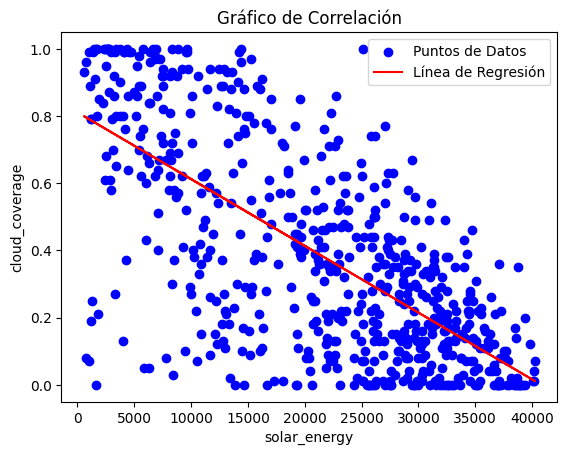

In [4]:
#Grafico de dispersion de los datos con linea de regresion
plt.scatter(solar_energy, cloud_coverage, label="Puntos de Datos", color="b")
slope, intercept = np.polyfit(solar_energy, cloud_coverage, 1)
regression_line = slope * solar_energy + intercept
print(f"Correlación de Pearson, con cobertura nubosa: {correlation:.2f}")
plt.plot(solar_energy, regression_line, color='r', label='Línea de Regresión')
# Etiquetas y título del gráfico
plt.xlabel("solar_energy")
plt.ylabel("cloud_coverage")
plt.title("Gráfico de Correlación")
plt.legend()
plt.show()

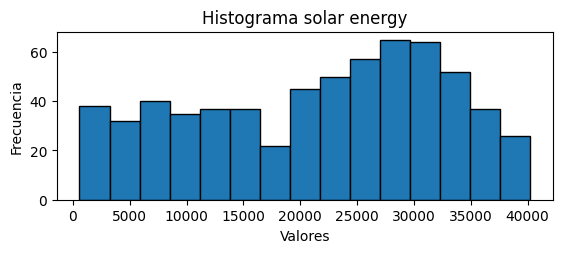

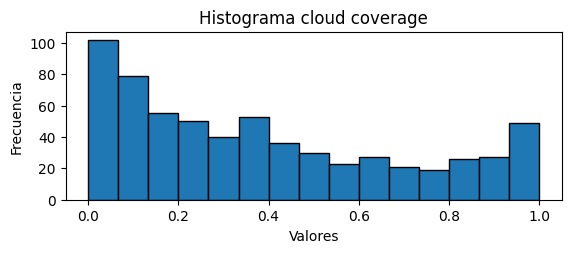

In [5]:
#histogramas de las variables para visualizar como se distribuyen los datos

plt.subplot(2, 1, 1) # 2 filas, 1 columna
plt.hist(solar_energy, bins=15, edgecolor='black')  # "bins" define el número de divisiones en el histograma
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma solar energy')
plt.show()

plt.subplot(2, 1, 2)
plt.hist(cloud_coverage, bins=15, edgecolor='black') 
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma cloud coverage')
plt.show()

En la cobertura nubosa la mayor frecuencia de datos es en 0, esto puede tener alguna consecuencia en el aprendizaje del modelo? Debido a que al ingresar los inputs al modelo estos se multiplican con los pesos y luego se suman, un valor de 0 podria nno aportaria informacion al proceso de aprendizaje (es lo mismo que ocurre con datos en horario de noche, no hay radiacion por lo que no aportan al aprendizaje)

Se invertira la escala de 'cloud_coverage', es decir, originalmente los datos van de [0,1] con menor cobertura nubosa a mayor. Ahora dejaremos los datos de esta forma [1,0] una menor cobertura nubosa corresponde a valores cercanos a 1 y viceversa. 

Correlación de Pearson, con cobertura nubosa [1,0]: 0.69


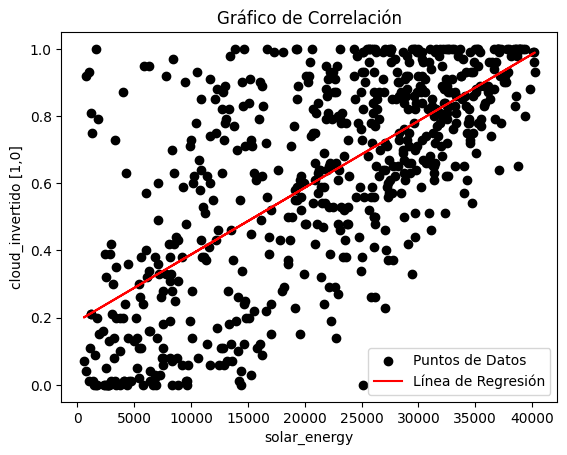

In [6]:
#escala de cloud_coverage invertida
 
#un valor de 1, significa que no hay cobertura nubosa
#un valor de 0, significa que hay cobertura nubosa
cloud_invertido = 1 - cloud_coverage 

correlation = data['Solar energy'].corr(cloud_invertido) 
print(f"Correlación de Pearson, con cobertura nubosa [1,0]: {correlation:.2f}")

plt.scatter(solar_energy, cloud_invertido, label="Puntos de Datos", color="black")
slope, intercept = np.polyfit(solar_energy, cloud_invertido, 1)
regression_line = slope * solar_energy + intercept
plt.plot(solar_energy, regression_line, color='r', label='Línea de Regresión')
# Etiquetas y título del gráfico
plt.xlabel("solar_energy")
plt.ylabel("cloud_invertido [1,0]")
plt.title("Gráfico de Correlación")
plt.legend()
plt.show()

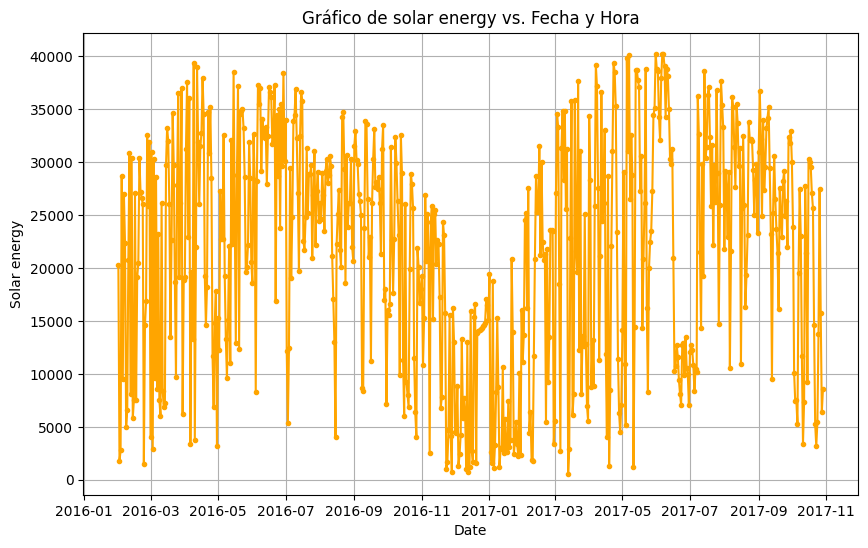

In [7]:
#Observando la serie de tiempo de 'Solar energy'

#5/30/2017 formato de fecha original
#pasamos el vector de fechas a otro formato, utilizando la funcion datetime
fechas = pd.to_datetime(fecha, format="%m/%d/%Y")

#dejamos todos los datos en un dataframe (o matriz)
df = pd.DataFrame({'Fecha': fechas, 'Valores': solar_energy, 'Cloud' : cloud_invertido})
#df = df.sort_values(by='Fecha') para ordenar en caso de que no estuviese en orden cronologico

#Crear el gráfico de la serie de tiempo
#lamentablemente no se expresa la unidad de la energia solar en la base de datos, pero debiese estar en W/m^2
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.plot(df['Fecha'], df['Valores'], marker='.', linestyle='-',color='orange')
plt.title('Gráfico de solar energy vs. Fecha y Hora')
plt.xlabel('Date')
plt.ylabel('Solar energy')
plt.grid(True)

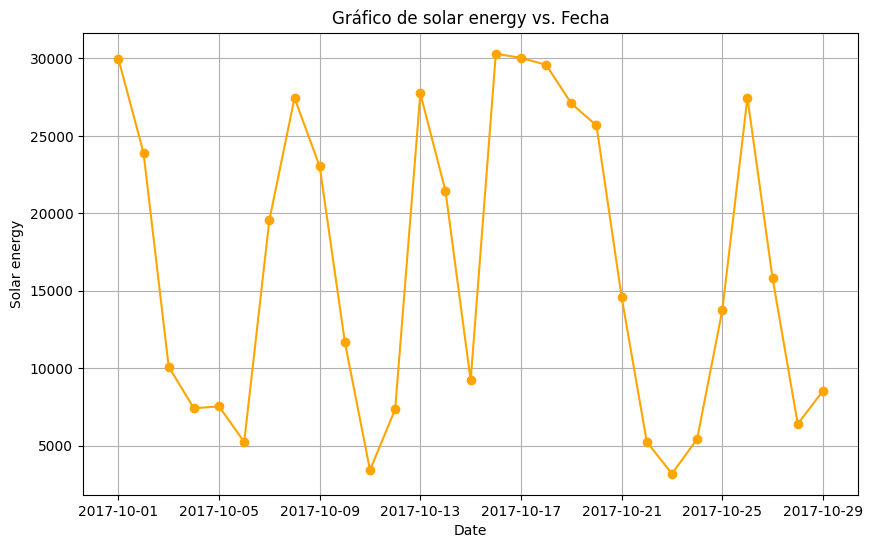

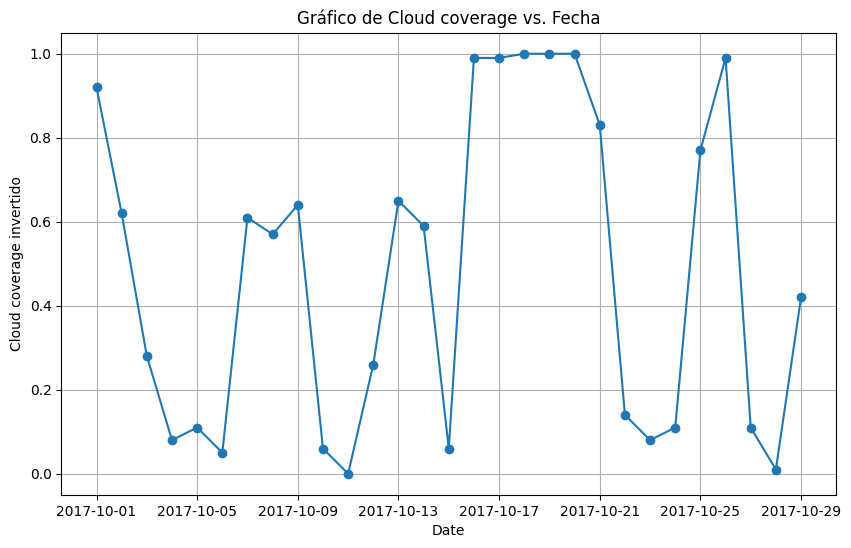

In [8]:
#graficando solo el ultimo mes de datos 
semana1_df = df.iloc[608:,]

plt.figure(figsize=(10, 6))
plt.plot(semana1_df['Fecha'], semana1_df['Valores'], marker='o', linestyle='-', color='orange')
plt.title('Gráfico de solar energy vs. Fecha')
plt.xlabel('Date')
plt.ylabel('Solar energy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))  
plt.plot(semana1_df['Fecha'], semana1_df['Cloud'], marker='o', linestyle='-')
plt.title('Gráfico de Cloud coverage vs. Fecha')
plt.xlabel('Date')
plt.ylabel('Cloud coverage invertido')
plt.grid(True)
plt.show()


In [9]:
# Para ingresar los datos a al modelo es necesario que esten normalizados pues facilita el ajuste 

#en este caso cloud coverage ya se encuentra en un rango de valores entre 0 y 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Valores', 'Cloud']] = scaler.fit_transform(df[['Valores', 'Cloud']])
print(df)

         Fecha   Valores  Cloud
0   2016-02-01  0.496054   0.90
1   2016-02-02  0.029774   0.20
2   2016-02-03  0.055338   0.13
3   2016-02-04  0.708811   0.63
4   2016-02-05  0.225312   0.48
..         ...       ...    ...
632 2017-10-25  0.331703   0.77
633 2017-10-26  0.677802   0.99
634 2017-10-27  0.383638   0.11
635 2017-10-28  0.146729   0.01
636 2017-10-29  0.200605   0.42

[637 rows x 3 columns]


In [113]:
#Una vez normalizados, se necesita que sean datos supervisados 

data = df
#definir el tamaño del paso (look-back), por ejemplo, 2
look_back = 1
X, y = [], [] #para las secuencias temporales de entrada (X) y salida (y)

for i in range(len(data) - look_back):
    #crea una secuencia temporal de cloud
    seq_cloud = data['Cloud'][i:i+look_back].tolist()
    
    #obtiene el valor de energia solar en el siguiente paso de tiempo
    target = data['Valores'][i+look_back]
    
    # Agrega la secuencia temporal a X y el valor de salida a y
    X.append(seq_cloud)
    y.append(target)

# Convierte las listas X y y en DataFrames si es necesario
X = pd.DataFrame(X, columns=[f'Cloud(t-{i})' for i in range(look_back, 0, -1)])
y = pd.Series(y, name='Valores(t+1)')

# X contendrá las secuencias temporales de temperatura y y contendrá los valores de energía solar en el siguiente paso de tiempo
print(X)
print(y)

     Cloud(t-1)
0          0.90
1          0.20
2          0.13
3          0.63
4          0.48
..          ...
631        0.11
632        0.77
633        0.99
634        0.11
635        0.01

[636 rows x 1 columns]
0      0.029774
1      0.055338
2      0.708811
3      0.225312
4      0.665398
         ...   
631    0.331703
632    0.677802
633    0.383638
634    0.146729
635    0.200605
Name: Valores(t+1), Length: 636, dtype: float64


In [76]:
#construccion del modelo de prueba

#importar librerias necesarias
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Divide los datos en conjuntos de entrenamiento y prueba
#test size indica 0.8 son datos de entrenamiento y 0.2 de los datos son de testeo
#los datos se ordenan de forma aleatoria
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [114]:
# construyendo red neuronal

#se crea un modelo secuencial de Keras
model = Sequential()

#se agregan capas ocultas (ajustar segun conveniencia)
model.add(Dense(635, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(318, activation='relu'))
model.add(Dense(1))  #capa de salida

#compila el modelo con una función de perdida y un optimizador
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

#se entrena el modelo
model.fit(X_train, y_train, epochs=800, batch_size=635, verbose=2)

#se realizan las predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

#calcula el error Cuadrático Medio entre el valor de salida y el esperado)
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio en el conjunto de prueba: {mse:.2f}")

Epoch 1/800
1/1 - 1s - loss: 0.3829 - 571ms/epoch - 571ms/step
Epoch 2/800
1/1 - 0s - loss: 3.4437 - 7ms/epoch - 7ms/step
Epoch 3/800
1/1 - 0s - loss: 0.1197 - 11ms/epoch - 11ms/step
Epoch 4/800
1/1 - 0s - loss: 0.2247 - 19ms/epoch - 19ms/step
Epoch 5/800
1/1 - 0s - loss: 0.3197 - 10ms/epoch - 10ms/step
Epoch 6/800
1/1 - 0s - loss: 0.3288 - 5ms/epoch - 5ms/step
Epoch 7/800
1/1 - 0s - loss: 0.3189 - 12ms/epoch - 12ms/step
Epoch 8/800
1/1 - 0s - loss: 0.3029 - 10ms/epoch - 10ms/step
Epoch 9/800
1/1 - 0s - loss: 0.2799 - 13ms/epoch - 13ms/step
Epoch 10/800
1/1 - 0s - loss: 0.2518 - 5ms/epoch - 5ms/step
Epoch 11/800
1/1 - 0s - loss: 0.2202 - 20ms/epoch - 20ms/step
Epoch 12/800
1/1 - 0s - loss: 0.1860 - 10ms/epoch - 10ms/step
Epoch 13/800
1/1 - 0s - loss: 0.1507 - 13ms/epoch - 13ms/step
Epoch 14/800
1/1 - 0s - loss: 0.1172 - 5ms/epoch - 5ms/step
Epoch 15/800
1/1 - 0s - loss: 0.0902 - 14ms/epoch - 14ms/step
Epoch 16/800
1/1 - 0s - loss: 0.0760 - 12ms/epoch - 12ms/step
Epoch 17/800
1/1 - 0s -

Epoch 1/800
1/1 - 0s - loss: 0.0659 - 14ms/epoch - 14ms/step
Epoch 2/800
1/1 - 0s - loss: 0.0659 - 9ms/epoch - 9ms/step
Epoch 3/800
1/1 - 0s - loss: 0.0659 - 9ms/epoch - 9ms/step
Epoch 4/800
1/1 - 0s - loss: 0.0659 - 11ms/epoch - 11ms/step
Epoch 5/800
1/1 - 0s - loss: 0.0659 - 8ms/epoch - 8ms/step
Epoch 6/800
1/1 - 0s - loss: 0.0659 - 9ms/epoch - 9ms/step
Epoch 7/800
1/1 - 0s - loss: 0.0659 - 12ms/epoch - 12ms/step
Epoch 8/800
1/1 - 0s - loss: 0.0659 - 8ms/epoch - 8ms/step
Epoch 9/800
1/1 - 0s - loss: 0.0659 - 10ms/epoch - 10ms/step
Epoch 10/800
1/1 - 0s - loss: 0.0659 - 10ms/epoch - 10ms/step
Epoch 11/800
1/1 - 0s - loss: 0.0659 - 7ms/epoch - 7ms/step
Epoch 12/800
1/1 - 0s - loss: 0.0659 - 11ms/epoch - 11ms/step
Epoch 13/800
1/1 - 0s - loss: 0.0659 - 7ms/epoch - 7ms/step
Epoch 14/800
1/1 - 0s - loss: 0.0659 - 11ms/epoch - 11ms/step
Epoch 15/800
1/1 - 0s - loss: 0.0659 - 8ms/epoch - 8ms/step
Epoch 16/800
1/1 - 0s - loss: 0.0659 - 10ms/epoch - 10ms/step
Epoch 17/800
1/1 - 0s - loss: 0.0

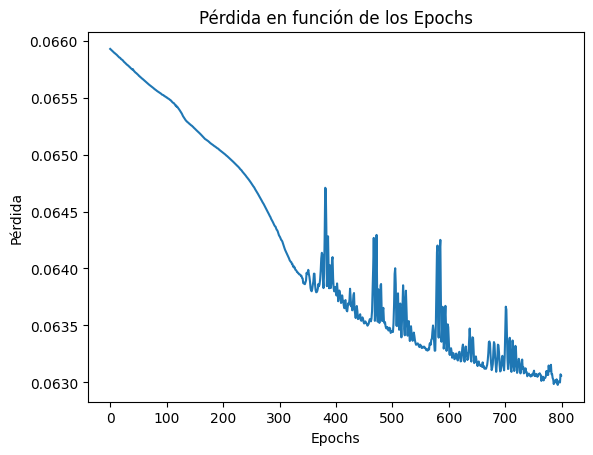

In [115]:
#grafico del aprendizaje durante el entrenamiento

import matplotlib.pyplot as plt
history = model.fit(X_train, y_train, epochs=800, batch_size=635, verbose=2)
#graficar la pérdida en función de los epochs
plt.plot(history.history['loss'])
plt.title('Pérdida en función de los Epochs')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.show()

2/2 [==============================] - 0s 3ms/step


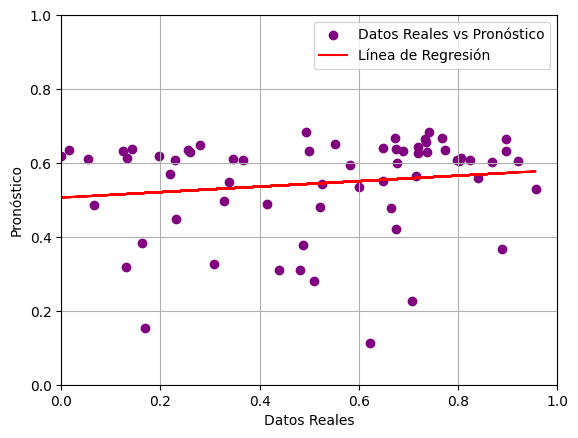

In [116]:
#realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

#graficar datos reales vs pronóstico
plt.scatter(y_test, y_pred, color='purple', label='Datos Reales vs Pronóstico')
slope, intercept = np.polyfit(y_test, y_pred, 1)
regression_line = slope * y_test + intercept
plt.plot(y_test, regression_line, color='r', label='Línea de Regresión')
plt.xlabel('Datos Reales')
plt.ylabel('Pronóstico')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Del grafico de dispersion y linea de regresion, notamos que el modelo no cumple lo esperado. Los datos pronosticados por el modelo no concuerdan casi nada con los reales, por lo que deberian probarse otros parametros que definan la red neuronal que entreguen mejores resultados.

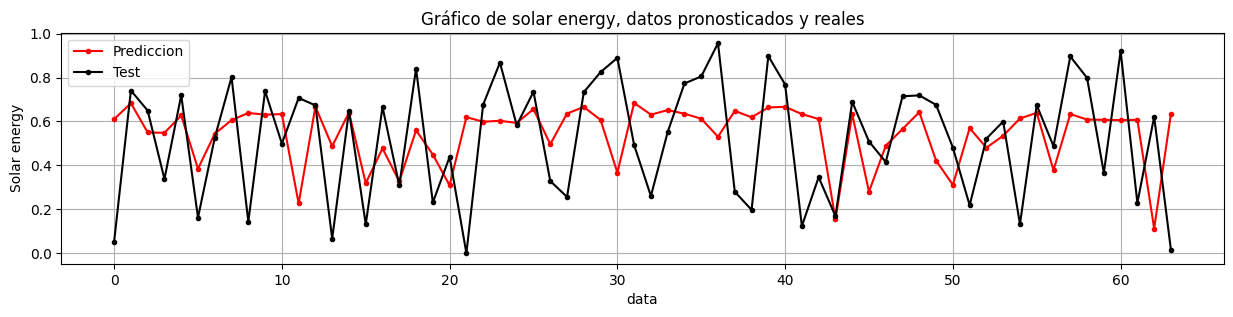

In [117]:
#grafico de linea 
serie= y_test
serie_reset = serie.reset_index(drop=True)
plt.figure(figsize=(15, 3))  # Tamaño del gráfico
plt.plot(y_pred, marker='.', linestyle='-', color='r',label='Prediccion')
plt.plot(serie_reset, marker='.', linestyle='-', color='k', label='Test')
plt.title('Gráfico de solar energy, datos pronosticados y reales')
plt.xlabel('data')
plt.ylabel('Solar energy')
plt.legend()
plt.grid(True)
plt.show()

De acuerdo a este grafico, se observa un comportamiento similar en cuanto a forma en algunos sectores, pero tambien un desfase en los datos pronosticados (el modelo subestima). 